In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import SimpleITK as sitk
import matplotlib.pyplot as plt

/mnt/cache/machenglong/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Archive Structure
The AAPM-Myo dataset can be downloaded from: [CT Clinical Innovation Center](https://ctcicblog.mayo.edu/2016-low-dose-ct-grand-challenge/)
(or the [box link](https://aapm.app.box.com/s/eaw4jddb53keg1bptavvvd1sf4x3pe9h/folder/144594475090)).

Here we only download the image data for demonstration.
And the tree structure for training data directory is shown as below:
```
____Training_Image_Data
  |____1mm B30
  |  |____full_1mm (unzipped from FD_1mm.zip)
  |  |  |____L067
  |  |  |  |____full_1mm
  |  |  |     |____L067_FD_1_1.CT.0001.0001.2015.12.22.18.09.40.840353.358074219.IMA (target file)
  |  |  |     |____...
  |  |  |     |____L067_FD_1_1.CT.0001.0560.2015.12.22.18.09.40.840353.358090018.IMA
  |  |  |
  |  |  |____L096
  |  |  |____...
  |  |  |____L506
  |  |____quarter_1mm (unzipped from QD_1mm.zip)
  |____1mm D45
  |  |____full_1mm_sharp (unzipped from FD_1mm_sharp.zip)
  |  |____quarter_1mm_sharp (unzipped from QD_1mm_sharp.zip)
  |____3mm B30
  |  |____full_3mm (unzipped from FD_3mm.zip)
  |  |____quarter_3mm (unzipped from QD_3mm.zip)
  |____3mm D45
    |____full_3mm_sharp (unzipped from FD_3mm_sharp.zip)
    |____quarter_3mm_sharp (unzipped from QD_3mm_sharp.zip)
```

Let's make it clear what's the difference between 1mm/3mm, b35/d45 and full/quarter.
According to the [AAPM website](https://www.aapm.org/grandchallenge/lowdosect/):
- QD is for quarter-dose image, FD is for full-dose data.
- b35/d45 represents the sharpness of the reconstruction kernels (Siemens B30 and D45, respectively).
  - The reconstruction kernel (a.k.a. “filter” or “algorithm”), is one of the most important parameters that affect the image quality. 
  - Generally, a sharper kernel generates images with higher spatial resolution, but increases the image noise.
- 1mm/3mm represents different image thickness, and this can be chosen according to the preference of the researchers.

Test data consisted of either the quarter-dose image data (in 1 or 3 mm image thicknesses) or projection data; no full dose data were provided, and only 1 or 3 mm thick image data or the projection data were provided.

In [2]:
def ima2array(ima_path):
    return sitk.GetArrayFromImage(sitk.ReadImage(ima_path))

def get_array_info(array):
    return (array.shape, (array.min(), array.max()), array.dtype)

def show_multiple_images(nrows, ncols, images, titles=None, tight=False, cmaps='gray'):
    num_imgs = len(images)
    num_plots = int(nrows * ncols)
    assert num_imgs <= num_plots, f'num_imgs = {num_imgs}, nrows = {nrows}, ncols = {ncols}.'
    cmaps = [cmaps] * num_imgs if not isinstance(cmaps, (list, tuple)) else cmaps
    fig, axes = plt.subplots(nrows, ncols, squeeze=False)
    axes = axes.flatten()
    for i in range(num_imgs):
        if isinstance(images[i], torch.Tensor):
            axes[i].imshow(images[i].cpu().squeeze(), cmap=cmaps[i])
        else:
            axes[i].imshow(images[i].squeeze(), cmap=cmaps[i])
        axes[i].axis('off')
        if titles is not None:
            axes[i].set_title(titles[i])
    
    if num_imgs < num_plots:
        for i in range(num_imgs, num_plots):
            axes[i].axis('off')
    if tight:
        fig.tight_layout()


def show_multiple_curves(nrows, ncols, arrays, xarrays=None, titles=None, xlabels=None, ylabels=None, tight=False, xlogs=None, ylogs=None):
    num_imgs = len(arrays)
    num_plots = int(nrows * ncols)
    assert num_imgs <= num_plots, f'num_imgs = {num_imgs}, nrows = {nrows}, ncols = {ncols}.'
    xarrays = [[_ for _ in range(len(a))] for a in arrays] if xarrays is None else xarrays
    xlogs = [xlogs] * num_plots if not isinstance(xlogs, (list, tuple)) else xlogs
    ylogs = [ylogs] * num_plots if not isinstance(ylogs, (list, tuple)) else ylogs
    fig, axes = plt.subplots(nrows, ncols)
    axes = axes.flatten()
    for i in range(num_imgs):
        axes[i].plot(xarrays[i], arrays[i])
        # axes[i].axis('off')
        if xlogs[i]:
            axes[i].set_xscale("log")
        if ylogs[i]:
            axes[i].set_yscale("log")

        if titles is not None:
            axes[i].set_title(titles[i])
        if xlabels is not None:
            axes[i].set_xlabel(xlabels[i])
        if ylabels is not None:
            axes[i].set_ylabel(ylabels[i])
    
    if num_imgs < num_plots:
        for i in range(num_imgs, num_plots):
            axes[i].axis('off')
    if tight:
        fig.tight_layout()


# Peek on the Data

In [73]:
# We first rename all "1mm B30"-like folder as "1mm_B30".

train_dir = '/mnt/cache/machenglong/data/aapm/Training_Image_Data'
source_folders = os.listdir(train_dir)
print(source_folders)

for source_folder in source_folders:
    source_folder_ = source_folder.replace(' ', '_')
    source_dir = os.path.join(train_dir, source_folder)
    source_dir_ = os.path.join(train_dir, source_folder_)
    os.rename(source_dir, source_dir_)

print(os.listdir(train_dir))

['1mm_D45', '3mm_B30', '3mm_D45', '1mm B30', '1mm_B30_1']
['1mm_D45', '3mm_B30', '1mm_B30', '3mm_D45', '1mm_B30_1']


In [16]:
dir_1mm_b30_fd = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30/full_1mm/L067/full_1mm'
dir_3mm_b30_fd = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/3mm_B30/full_3mm/L067/full_3mm'
path_1mm_b30_fd = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30/full_1mm/L067/full_1mm/L067_FD_1_1.CT.0001.0001.2015.12.22.18.09.40.840353.358074219.IMA'
path_1mm_b30_qd = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30/quarter_1mm/L067/quarter_1mm/L067_QD_1_1.CT.0003.0001.2015.12.22.18.10.55.420810.358276339.IMA'
path_1mm_d45_fd = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_D45/full_1mm_sharp/L067/full_1mm_sharp/L067_FD_1_SHARP_1.CT.0002.0001.2016.01.21.18.11.40.977560.404629015.IMA'
path_3mm_b30_fd = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/3mm_B30/full_3mm/L067/full_3mm/L067_FD_3_1.CT.0002.0001.2015.12.22.18.12.07.5968.358090401.IMA'

names = ('1mm-b30-fd', '1mm-b30-qd', '1mm-d45-fd', '3mm-b30-fd')
paths = (path_1mm_b30_fd, path_1mm_b30_qd, path_1mm_d45_fd, path_3mm_b30_fd)
arrays = [ima2array(p) for p in paths]
for i in range(len(names)):
    print('Shape/Range/Type of ', names[i], ':', get_array_info(arrays[i]))


Shape/Range/Type of  1mm-b30-fd : ((1, 512, 512), (-1024, 1310), dtype('int16'))
Shape/Range/Type of  1mm-b30-qd : ((1, 512, 512), (-1024, 1336), dtype('int16'))
Shape/Range/Type of  1mm-d45-fd : ((1, 512, 512), (-1024, 1432), dtype('int16'))
Shape/Range/Type of  3mm-b30-fd : ((1, 512, 512), (-1024, 1185), dtype('int16'))


560 224


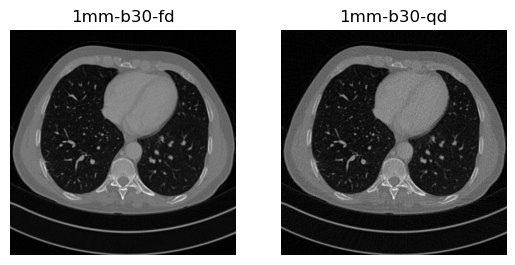

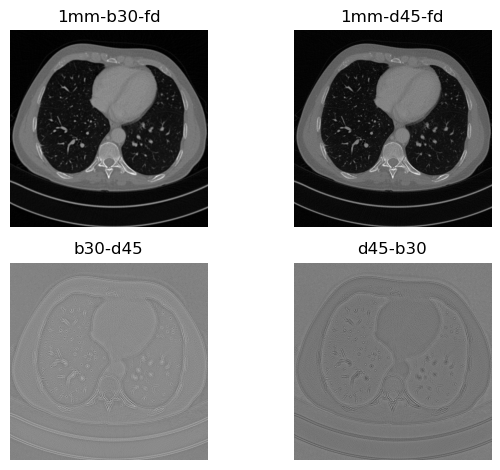

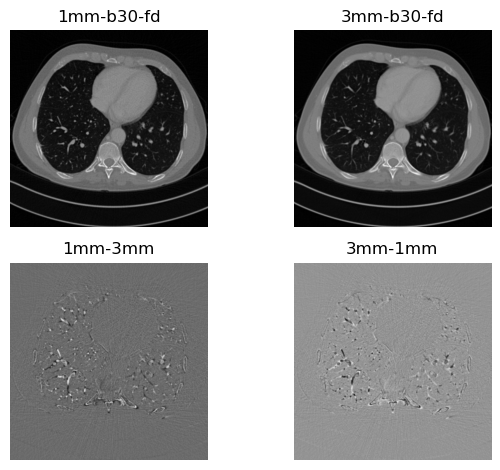

In [29]:
# quarter version contains low-dose noise
show_multiple_images(1, 2, arrays[:2], names[:2])

# D45 contains sharper content
show_multiple_images(2, 2, [arrays[0], arrays[2], arrays[0]-arrays[2], arrays[2]-arrays[0]], [names[0], names[2], 'b30-d45', 'd45-b30'], tight=True)

# 3mm contains less slices
show_multiple_images(2, 2, [arrays[0], arrays[3], arrays[0]-arrays[3], arrays[3]-arrays[0]], [names[0], names[3], '1mm-3mm', '3mm-1mm'], tight=True)
print(len(os.listdir(dir_1mm_b30_fd)), len(os.listdir(dir_3mm_b30_fd)))

# Rearrange the Data
Now we want to rearrange the .IMA files.

For now, we might as well use the 1mm B30 version only. For each version, data from several patients will be chosen as training set, and the rest as validation set. 

Let's first remove the redundant directories and check the number of slices in the data of each patient.

In [10]:
import shutil

# target_dir = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30'
target_dir = '/mnt/cache/machenglong/data/aapm/Testing_Image_Data/3mm_D45'

doses = os.listdir(target_dir)
for dose in doses:
    dose_dir = os.path.join(target_dir, dose)
    patients = sorted(os.listdir(dose_dir))
    for patient in patients:
        patient_dir = os.path.join(dose_dir, patient)
        patient_dir_red = os.path.join(patient_dir, dose)
        
        if os.path.exists(patient_dir_red):
            print('Moving files from redundant directory: ', patient_dir_red)
            file_names = sorted(os.listdir(patient_dir_red))

            for file_name in file_names:
                file_path_old = os.path.join(patient_dir_red, file_name)
                file_path_new = os.path.join(patient_dir, file_name)
                shutil.move(file_path_old, file_path_new)
    
            if len(os.listdir(patient_dir_red)) == 0:
                shutil.rmtree(patient_dir_red)
            print('Files moved to directory: ', patient_dir)
            # break


Moving files from redundant directory:  /mnt/cache/machenglong/data/aapm/Testing_Image_Data/3mm_D45/quarter_3mm_sharp/L008/quarter_3mm_sharp
Files moved to directory:  /mnt/cache/machenglong/data/aapm/Testing_Image_Data/3mm_D45/quarter_3mm_sharp/L008
Moving files from redundant directory:  /mnt/cache/machenglong/data/aapm/Testing_Image_Data/3mm_D45/quarter_3mm_sharp/L031/quarter_3mm_sharp
Files moved to directory:  /mnt/cache/machenglong/data/aapm/Testing_Image_Data/3mm_D45/quarter_3mm_sharp/L031
Moving files from redundant directory:  /mnt/cache/machenglong/data/aapm/Testing_Image_Data/3mm_D45/quarter_3mm_sharp/L057/quarter_3mm_sharp
Files moved to directory:  /mnt/cache/machenglong/data/aapm/Testing_Image_Data/3mm_D45/quarter_3mm_sharp/L057
Moving files from redundant directory:  /mnt/cache/machenglong/data/aapm/Testing_Image_Data/3mm_D45/quarter_3mm_sharp/L061/quarter_3mm_sharp
Files moved to directory:  /mnt/cache/machenglong/data/aapm/Testing_Image_Data/3mm_D45/quarter_3mm_sharp/L

# Transform the Data to .NPY Format

In [79]:

target_dir = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30'

doses = os.listdir(target_dir)
for dose in doses:
    dose_dir = os.path.join(target_dir, dose)
    patients = sorted(os.listdir(dose_dir))  # dangerous!
    for patient in patients:
        patient_dir = os.path.join(dose_dir, patient)
        ima_files = sorted([_ for _ in os.listdir(patient_dir) if '.IMA' in _])

        for ima_file in ima_files:
            arr_file = ima_file.replace('.IMA', '.npy')
            ima_path = os.path.join(patient_dir, ima_file)
            arr_path = os.path.join(patient_dir, arr_file)

            if os.path.exists(ima_path) and not os.path.exists(arr_path):
                arr = ima2array(ima_path)                
                np.save(arr_path, arr)
                print('.npy file saved: ', arr_file)
            
        for ima_file in ima_files:
            arr_file = ima_file.replace('.IMA', '.npy')
            ima_path = os.path.join(patient_dir, ima_file)
            arr_path = os.path.join(patient_dir, arr_file)
            if os.path.exists(ima_path) and os.path.exists(arr_path):
                os.unlink(ima_path)
                print('.IMA file deleted: ', ima_file)
            

.npy file saved:  L096_FD_1_1.CT.0005.0001.2015.12.23.16.31.08.619651.360772428.npy
.npy file saved:  L096_FD_1_1.CT.0005.0002.2015.12.23.16.31.08.619651.360772452.npy
.npy file saved:  L096_FD_1_1.CT.0005.0003.2015.12.23.16.31.08.619651.360772476.npy
.npy file saved:  L096_FD_1_1.CT.0005.0004.2015.12.23.16.31.08.619651.360772500.npy
.npy file saved:  L096_FD_1_1.CT.0005.0005.2015.12.23.16.31.08.619651.360772524.npy
.npy file saved:  L096_FD_1_1.CT.0005.0006.2015.12.23.16.31.08.619651.360772548.npy
.npy file saved:  L096_FD_1_1.CT.0005.0007.2015.12.23.16.31.08.619651.360772572.npy
.npy file saved:  L096_FD_1_1.CT.0005.0008.2015.12.23.16.31.08.619651.360772596.npy
.npy file saved:  L096_FD_1_1.CT.0005.0009.2015.12.23.16.31.08.619651.360772620.npy
.npy file saved:  L096_FD_1_1.CT.0005.0010.2015.12.23.16.31.08.619651.360772644.npy
.npy file saved:  L096_FD_1_1.CT.0005.0011.2015.12.23.16.31.08.619651.360772668.npy
.npy file saved:  L096_FD_1_1.CT.0005.0012.2015.12.23.16.31.08.619651.360772

In [80]:
import time

print(len(os.listdir('/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30/full_1mm/L067/')))
print(len(os.listdir('/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30_copy/full_1mm/L067/')))

t11 = time.time()
for _ in range(100):
    a = ima2array('/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30_copy/full_1mm/L067/L067_FD_1_1.CT.0001.0001.2015.12.22.18.09.40.840353.358074219.IMA')
t12 = time.time()
print((t12 - t11)/100)

t21 = time.time()
for _ in range(100):
    b = np.load('/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30/full_1mm/L067/L067_FD_1_1.CT.0001.0001.2015.12.22.18.09.40.840353.358074219.npy')
t22 = time.time()
print((t22-t21)/100)

0.006795806884765625
0.0006958460807800293


# Split Training and Validation Dataset

In [108]:
patients_dir = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30/full_1mm/'
patients = sorted(os.listdir(patients_dir))
data_len_dict = {}
for patient in patients:
    patient_dir = os.path.join(patients_dir, patient)
    num_slices = len(os.listdir(patient_dir))
    data_len_dict[patient] = num_slices
    # print(f'Data from Patient {patient} contain {num_slices} slices.')


def get_least_n_data_patient(data_len_dict, num_choices=2):
    def loop_min(some_dict):
        min_num = 16384
        patient_min = None
        for patient, num in some_dict.items():
            if num < min_num:
                min_num = num
                patient_min = patient
        min_num = some_dict.pop(patient_min)
        return patient_min, min_num, some_dict

    rest_dict = data_len_dict.copy()
    least_dict = {}
    for i in range(num_choices):
        patient_min, num_min, rest_dict = loop_min(rest_dict)
        least_dict.update({patient_min: num_min})
        print(f'Least {i+1} data found in {patient_min} with {num_min} image pairs.')

    return rest_dict, least_dict

train_dict, val_dict = get_least_n_data_patient(data_len_dict, num_choices=2)
num_train = sum(train_dict.values())
num_val = sum(val_dict.values())
num_total = sum(data_len_dict.values())

print(f'In total, there are {num_total} slices from {len(patients)} patients.')
print(f'{len(val_dict)} Patients with least data are in {val_dict}.')
print(f'We choose these 2 patients as validation set, consisting of {num_val} image pairs, making up {num_val/num_total * 100}%.')
print(f'The rest will construct our training set, consisting of {num_train} image pairs, making up {num_train/num_total * 100}%.')

Least 1 data found in L109 with 318 image pairs.
Least 2 data found in L286 with 525 image pairs.
In total, there are 5936 slices from 10 patients.
2 Patients with least data are in {'L109': 318, 'L286': 525}.
We choose these 2 patients as validation set, consisting of 843 image pairs, making up 14.201482479784367%.
The rest will construct our training set, consisting of 5093 image pairs, making up 85.79851752021564%.


In [112]:
def get_path_list_from_dir(source_dir, ext='.npy', keyword=''):
    # source_dir should contain only the target files
    return sorted([os.path.join(source_dir, _) for _ in os.listdir(source_dir) if ext in _ and keyword in _])

def get_path_list_from_patients(root_dir, patient_list, ext='.npy', keyword='', full_dose=True):
    # root_dir = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30/'
    doses = os.listdir(root_dir)
    assert len(doses) == 2, f'Only full and quarter dose.'
    dose = [_ for _ in doses if 'full' in _][0] if full_dose else [_ for _ in doses if 'full' not in _][0]
    patient_dir = os.path.join(root_dir, dose)
    path_list = []

    for patient in patient_list:
        npy_dir = os.path.join(patient_dir, patient)
        path_list += get_path_list_from_dir(npy_dir, ext=ext, keyword=keyword)
        
    return sorted(path_list)

In [143]:
import shutil

def make_dirs_if_not_exist(input_dir):
    if not os.path.exists(input_dir):
        os.makedirs(input_dir)
        print(f'Directory created: {input_dir}.')

def copy_pair_to_new_dir(low_dir_new, full_dir_new, low_paths, full_paths):
    for i, (path_low, path_full) in enumerate(zip(low_paths, full_paths)):
        name_low = path_low.split('/')[-1]
        name_full = path_full.split('/')[-1]
        path_low_new = os.path.join(low_dir_new, name_low)
        path_full_new = os.path.join(full_dir_new, name_full)
        shutil.copy(path_low, path_low_new)
        shutil.copy(path_full, path_full_new)

train_patient_list = sorted([_ for _ in train_dict.keys()])
val_patient_list = sorted([_ for _ in val_dict.keys()])
root_dir = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30'
train_low_list = get_path_list_from_patients(root_dir, train_patient_list, ext='.npy', full_dose=False)
train_full_list = get_path_list_from_patients(root_dir, train_patient_list, ext='.npy', full_dose=True)
val_low_list = get_path_list_from_patients(root_dir, val_patient_list, ext='.npy', full_dose=False)
val_full_list = get_path_list_from_patients(root_dir, val_patient_list, ext='.npy', full_dose=False)

train_dir_new = '/mnt/cache/machenglong/data/aapm/train'
val_dir_new = '/mnt/cache/machenglong/data/aapm/val'
train_low_dir_new = os.path.join(train_dir_new, 'low')
train_full_dir_new = os.path.join(train_dir_new, 'full')
val_low_dir_new = os.path.join(val_dir_new, 'low')
val_full_dir_new = os.path.join(val_dir_new, 'full')

make_dirs_if_not_exist(train_low_dir_new)
make_dirs_if_not_exist(train_full_dir_new)
make_dirs_if_not_exist(val_low_dir_new)
make_dirs_if_not_exist(val_full_dir_new)

copy_pair_to_new_dir(train_low_dir_new, train_full_dir_new, train_low_list, train_full_list)
copy_pair_to_new_dir(val_low_dir_new, val_full_dir_new, val_low_list, val_full_list)


Directory created: /mnt/cache/machenglong/data/aapm/train/low.
Directory created: /mnt/cache/machenglong/data/aapm/train/full.
Directory created: /mnt/cache/machenglong/data/aapm/val/low.
Directory created: /mnt/cache/machenglong/data/aapm/val/full.


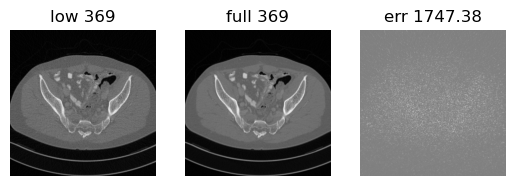

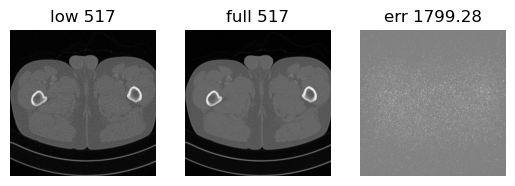

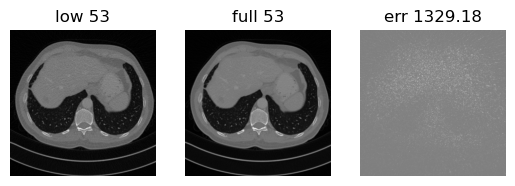

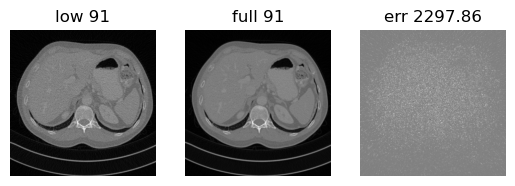

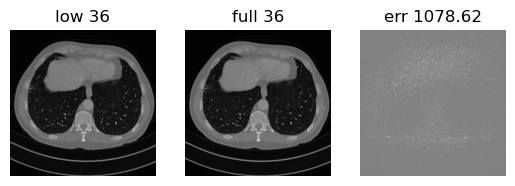

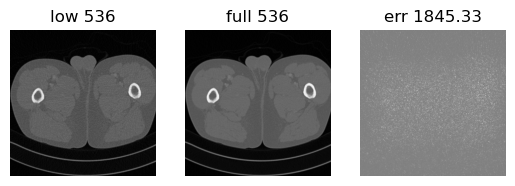

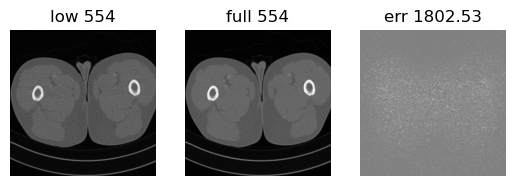

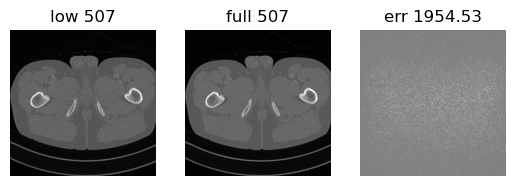

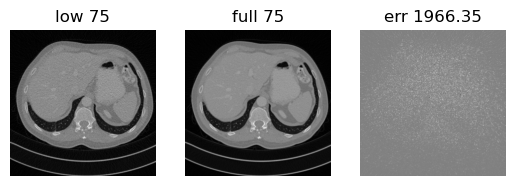

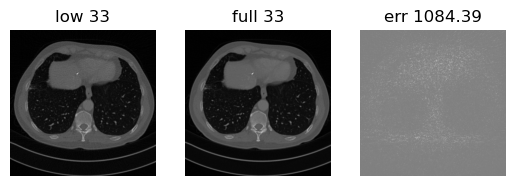

In [138]:
a = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30/quarter_1mm/L067/'
b = '/mnt/cache/machenglong/data/aapm/Training_Image_Data/1mm_B30/full_1mm/L067/'
npysa = sorted(os.listdir(a))
npysb = sorted(os.listdir(b))
assert len(npysa) == len(npysb), f'{len(npysa)} != {len(npysb)}.'
perm_indices = np.random.permutation(len(npysa))

count = 0
for i in perm_indices:
    count += 1
    npya = npysa[i]
    npyb = npysb[i]
    patha = os.path.join(a, npya)
    pathb = os.path.join(b, npyb)
    imga = np.load(patha)
    imgb = np.load(pathb)
    err = np.square(imga - imgb)
    show_multiple_images(1, 3, [imga, imgb, err], titles=[f'low {i}', f'full {i}', 'err %.2f' % (err.mean())])
    if count == 10: break

In [157]:
import cv2
import sys
sys.path.append('..')
from utilities.ct_tools import CTTool

low_hu = np.load('/mnt/cache/machenglong/data/aapm/train/low/L067_QD_1_1.CT.0003.0001.2015.12.22.18.10.55.420810.358276339.npy').squeeze()
full_hu = np.load('/mnt/cache/machenglong/data/aapm/train/full/L067_FD_1_1.CT.0001.0001.2015.12.22.18.09.40.840353.358074219.npy').squeeze()
W, H = low_hu.shape[-1], low_hu.shape[-2]
assert W == full_hu.shape[-1] and H == full_hu.shape[-2], f'low HU shape: {low_hu.shape}, full HU shape: {full_hu.shape}.'
print(low_hu.shape)
dataset_shape = (628, 628)
cttool = CTTool()

t11 = time.time()
for _ in range(100):
    low_hu1 = cv2.resize(low_hu, dataset_shape, cv2.INTER_CUBIC)
    full_hu1 = cv2.resize(full_hu, dataset_shape, cv2.INTER_CUBIC)
    img_low1 = cttool.HU2mu(low_hu1)
    img_full1 = cttool.HU2mu(full_hu1)
    img_low1 = torch.from_numpy(img_low1).unsqueeze(0).float()
    img_full1 = torch.from_numpy(img_full1).unsqueeze(0).float()
t12 = time.time()
print((t12 - t11)/100)
print(img_low1.shape, img_full1.shape)

t21 = time.time()
hu = np.stack((low_hu, full_hu), -1)
print(hu.shape)
for _ in range(100):
    hu2 = cv2.resize(hu, dataset_shape, cv2.INTER_CUBIC)
    img2 = cttool.HU2mu(hu2)
    img2 = torch.from_numpy(hu2).float()
    img_low2 = img2[:,:,0].unsqueeze(0)
    img_full2 = img2[:,:,1].unsqueeze(0)
t22 = time.time()
print((t22 - t21)/100)
print(img_low2.shape, img_full2.shape)


(512, 512)
0.0026807022094726563
torch.Size([1, 628, 628]) torch.Size([1, 628, 628])
(512, 512, 2)
0.0041723489761352536
torch.Size([1, 628, 628]) torch.Size([1, 628, 628])
